In [38]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
import numpy as np
import pandas as pd
from keras.metrics import CategoricalAccuracy
from pandas import DataFrame
from keras.layers import TextVectorization
from sklearn.preprocessing import OneHotEncoder
import pickle
from keras.layers import Embedding, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Concatenate
from keras import initializers
from keras.utils import plot_model
from keras import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras_tuner import HyperParameters, RandomSearch, Objective
import keras
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf

env: TF_FORCE_GPU_ALLOW_GROWTH=true


# lecture du dataset

In [39]:
olid = pd.read_csv("../data/olid-training-v1.0.tsv", sep="\t")
olid

id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c  
0           UNT       NaN  
1           TIN       IND  
2           NaN       NaN  
3           UNT       NaN  
4           NaN       NaN  
...         ...       ...  
13235       TIN       IND  
13236       NaN       NaN  
13237       TIN       OTH  
13238       UNT       NaN  
13239       NaN       NaN  

[13240 rows x 5 columns]

# préparation des données – séparation en train set & valid set

In [41]:
train_data_a = olid['tweet']

lbl_train_a = olid['subtask_a']

In [42]:
train_data_b = []

lbl_train_b = []

for tweet, sb_b in zip(olid['tweet'], olid['subtask_b'].astype(str)):
    if sb_b != 'nan':
        train_data_b.append(tweet)
        lbl_train_b.append(sb_b)

In [43]:
train_data_c = []

lbl_train_c = []

for tweet, sb_c in zip(olid['tweet'], olid['subtask_c'].astype(str)):
    if sb_c != 'nan':
        train_data_c.append(tweet)
        lbl_train_c.append(sb_c)

# construction de la couche de vectorization

In [44]:
# int pour que les tokens soient représenter par des entiers plutôt que des vecteurs
vectorizer = TextVectorization(output_sequence_length=300, output_mode="int")
vectorizer.adapt(olid['tweet'],)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
vectorizer.vocabulary_size()

22418

# transformation des tweets en vecteurs d'entiers avec la méthode vectorizer

In [45]:
training_data_a = np.array(vectorizer(np.array(train_data_a)))
training_data_b = np.array(vectorizer(np.array(train_data_b)))
training_data_c = np.array(vectorizer(np.array(train_data_c)))

len(train_data_c)

3876

In [46]:
cat_to_int_a = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_a']))))}
label_train_a = np.array([cat_to_int_a[row] for row in lbl_train_a])

cat_to_int_a, label_train_a[:5]

({'NOT': 0, 'OFF': 1}, array([1, 1, 0, 1, 0]))

In [47]:
cat_to_int_b = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_b'].astype(str))))) if label != 'nan'}

In [48]:
label_train_b = []
for row in lbl_train_b:
    try :
        label_train_b.append(cat_to_int_b[row])
    except KeyError:
        continue

np.array(label_train_b).shape

(4400,)

In [50]:
cat_to_int_c = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_c'].astype(str))))) if label != 'nan'}

In [51]:
label_train_c = []

for row in lbl_train_c:
    try : 
        label_train_c.append(cat_to_int_c[row])
    except KeyError:
        continue
    
np.array(label_train_c).shape

(3876,)

comme les 3 inputs donnés au modèle lors de l'entrainement doivent être de la même dimension, ils font la taille de l'input de la tâche 3 car c'est le plus petit. Pour éviter de déséquilibrer encore plus les étiquettes en réduisant la taille des input 1 et 2, on fait en sorte que chaque input ait autant d'étiquettes de chaque classe

In [55]:
ros = RandomOverSampler()

training_data_a, label_train_a = ros.fit_resample(training_data_a, label_train_a)
training_data_b, label_train_b = ros.fit_resample(training_data_b, label_train_b)
training_data_c, label_train_c = ros.fit_resample(training_data_c, label_train_c)

df_a = pd.DataFrame(list(zip([x for x in training_data_a], label_train_a)), columns = ['data', 'label']);
df_b = pd.DataFrame(list(zip([x for x in training_data_b], label_train_b)), columns = ['data', 'label']);
df_c = pd.DataFrame(list(zip([x for x in training_data_c], label_train_c)), columns = ['data', 'label']);

df_train_a = pd.concat([df_a.query('label == 0').head(2407),
                        df_a.query('label == 1').head(2407)])

df_train_b = pd.concat([df_b.query('label == 0').head(2407),
                        df_b.query('label == 1').head(2407)])

df_train_c = pd.concat([df_c.query('label == 0').head(1604),
                        df_c.query('label == 1').head(1605),
                        df_c.query('label == 2').head(1605)])

print(df_train_a['label'].value_counts())
print(df_train_b['label'].value_counts())
print(df_train_c['label'].value_counts())

print(len(df_train_a['data']))
print(len(df_train_b['data']))
print(len(df_train_c['data']))

0    2407
1    2407
Name: label, dtype: int64
0    2407
1    2407
Name: label, dtype: int64
1    1605
2    1605
0    1604
Name: label, dtype: int64
4814
4814
4814


# transformation des labels en one hot

In [56]:
ohe = OneHotEncoder()

y_train_ohe_a = ohe.fit_transform(np.array(df_train_a['label']).reshape(-1,1)).toarray()

y_train_ohe_b = ohe.fit_transform(np.array(df_train_b['label']).reshape(-1,1)).toarray()

y_train_ohe_c = ohe.fit_transform(np.array(df_train_c['label']).reshape(-1,1)).toarray()


# chargement de la matrice d'embedding

In [57]:
embed_matrix = open("embedding_matrix-1000.pickle", 'rb')
embed_matrix = pickle.load(embed_matrix)
embed_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.76435 ,  0.17534 ,  0.12309 , ...,  0.33769 , -0.059361,
        -0.11667 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

# construction du modèle

In [58]:
def build_model(nb_filter=32,
                dropout=0.5,
                kernel=5,
                dense_units=64):
    # 1ère partie du modèle qui fera la classification de la tâche 1
    int_sequences_input = Input(shape=(None,), dtype="int64", name="input")
    embedding = Embedding(
        len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        len(embed_matrix[0]), # dimension des embedding de chaque mot
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=True,
        input_length=300)(int_sequences_input)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1a")(embedding)
    x = MaxPooling1D(5, name="max_pooling1d_1a")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2a")(x)
    x = MaxPooling1D(5, name="max_pooling1d_2a")(x)
    x = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3a")(x)
    x = GlobalMaxPooling1D(name="glob_max_pooling_a")(x)
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_a")(x)
    x = Dropout(dropout, name="dropout_a")(first_dense)
    preds_a = Dense(len(cat_to_int_a), activation="softmax", name="predict_task_a")(x)

    # 2ème partie du modèle qui fera la classification de la tâche 2
    int_sequences_input2 = Input(shape=(None,), name="input2")
    embedding2 = Embedding(len(embed_matrix), len(embed_matrix[0]), embeddings_initializer=initializers.Constant(embed_matrix), trainable=True, input_length=300, name='embedding2')(int_sequences_input2)
    y = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1b")(embedding2)
    y = MaxPooling1D(5, name="max_pooling1d_1b")(y)
    y = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2b")(y)
    y = MaxPooling1D(5, name="max_pooling1d_2b")(y)
    y = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3b")(y)
    y = GlobalMaxPooling1D(name="glob_max_pooling_b")(y)
    concat1 = Concatenate(name='concat1')([y, preds_a])
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_b")(concat1)
    y = Dropout(dropout, name="dropout_b")(first_dense)
    preds_b = Dense(len(cat_to_int_b), activation="softmax", name="predict_task_b")(y)

    # 3ème partie du modèle qui fera la classification de la tâche 3
    int_sequences_input3 = Input(shape=(None,), name="input3")
    embedding3 = Embedding(len(embed_matrix), len(embed_matrix[0]), embeddings_initializer=initializers.Constant(embed_matrix), trainable=True, input_length=300, name='embedding3')(int_sequences_input3)
    z = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_1c")(embedding3)
    z = MaxPooling1D(5, name="max_pooling1d_1c")(z)
    z = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_2c")(z)
    z = MaxPooling1D(5, name="max_pooling1d_2c")(z)
    z = Conv1D(nb_filter, kernel, activation="relu", name="conv1d_3c")(z)
    z = GlobalMaxPooling1D(name="glob_max_pooling_c")(z)
    concat2 = Concatenate(name='concat2')([z, preds_b])
    first_dense = Dense(dense_units, activation="relu", name="classif_dense_c")(concat2)
    z = Dropout(dropout, name="dropout_c")(first_dense)
    preds_c = Dense(len(cat_to_int_c), activation="softmax", name="predict_task_c")(z)


    model = Model(inputs=[int_sequences_input, int_sequences_input2, int_sequences_input3], outputs=[preds_a, preds_b, preds_c], name="model3")

    model.compile(optimizer="adam",
                    loss={
                        "predict_task_a" : "categorical_crossentropy",
                        "predict_task_b" : "categorical_crossentropy",
                        "predict_task_c" : "categorical_crossentropy"
                    },
                    metrics={
                        "predict_task_a" : CategoricalAccuracy(),
                        "predict_task_b" : CategoricalAccuracy(),
                        "predict_task_c" : CategoricalAccuracy()
                    }
                )
    
    return model

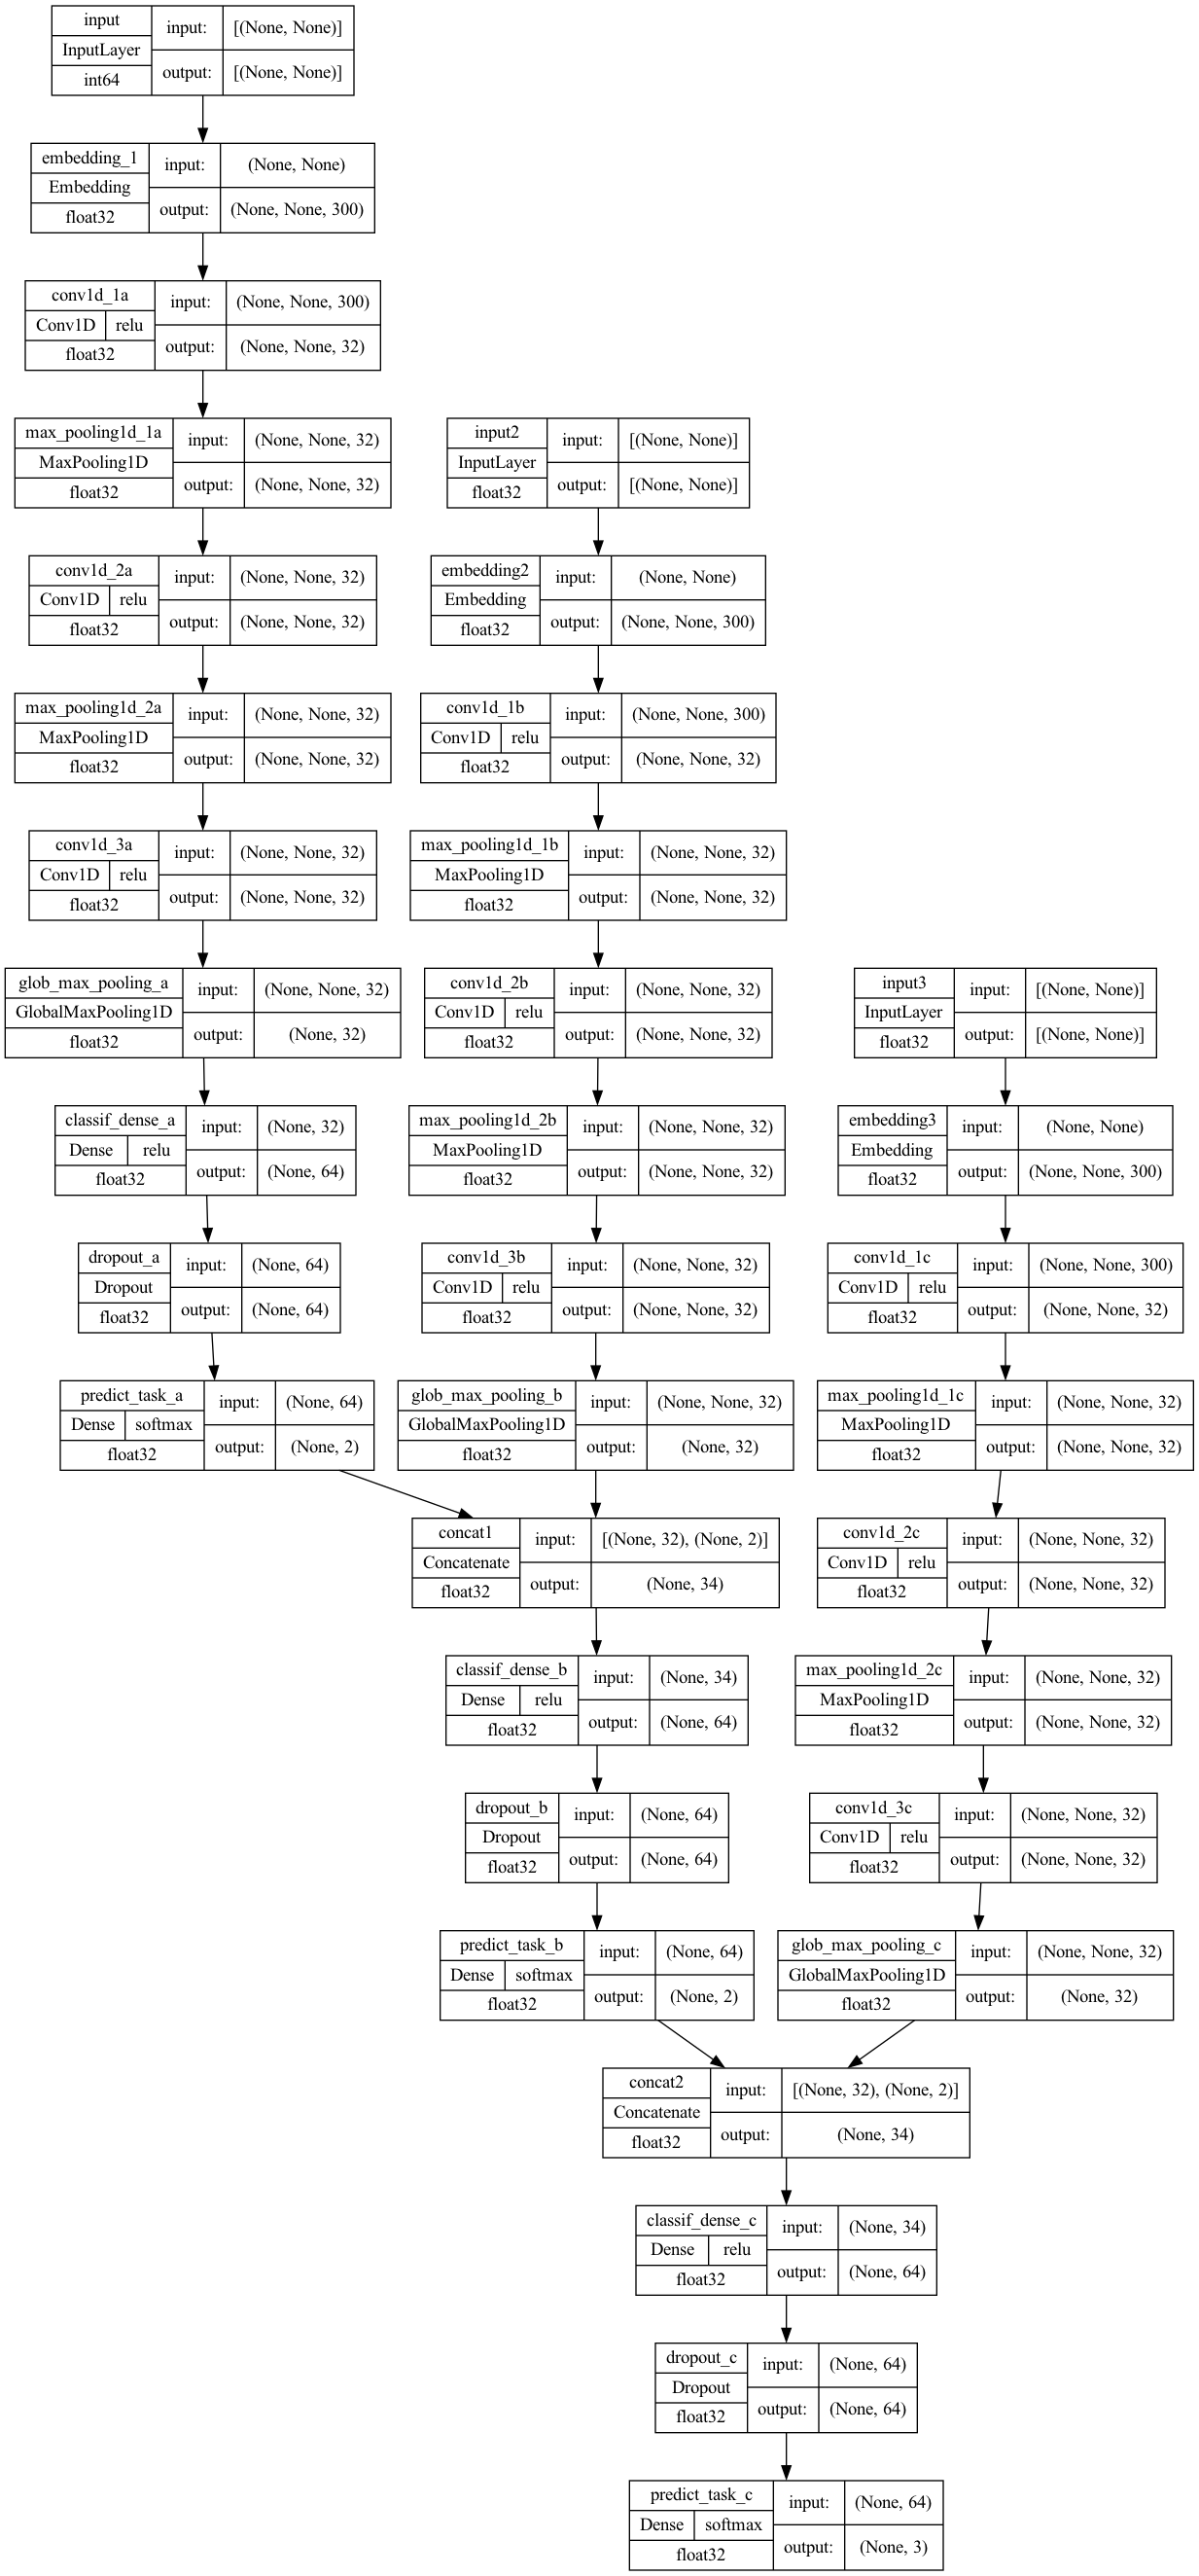

In [59]:
model = build_model()
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [60]:
early_val_loss = EarlyStopping("val_loss", verbose=1)
early_val_acc_a = EarlyStopping("val_predict_task_a_categorical_accuracy", verbose=1)
early_val_acc_b = EarlyStopping("val_predict_task_b_categorical_accuracy", verbose=1)
early_val_acc_c = EarlyStopping("val_predict_task_b_categorical_accuracy", verbose=1)

In [62]:
training_data_a = []
training_data_b = []
training_data_c = []

training_data_a = np.array([np.array(val) for val in df_train_a['data']])
training_data_b = np.array([np.array(val) for val in df_train_b['data']])
training_data_c = np.array([np.array(val) for val in df_train_c['data']])

len(training_data_a), len(training_data_b), len(training_data_c)

(4814, 4814, 4814)

In [63]:
model.fit(x={
            "input" : training_data_a,
            "input2" : training_data_b,
            "input3" : training_data_c
            },
            y={
                "predict_task_a": y_train_ohe_a,
                "predict_task_b": y_train_ohe_b,
                "predict_task_c": y_train_ohe_c
            },
            epochs=100, batch_size=64, validation_split=0.2,
            callbacks=[early_val_loss, early_val_acc_a, early_val_acc_b, early_val_acc_c])

Epoch 1/100
61/61 [==============================] - 45s 718ms/step - loss: 2.3041 - predict_task_a_loss: 0.6647 - predict_task_b_loss: 0.6322 - predict_task_c_loss: 1.0072 - predict_task_a_categorical_accuracy: 0.6217 - predict_task_b_categorical_accuracy: 0.6489 - predict_task_c_categorical_accuracy: 0.4931 - val_loss: 3.3490 - val_predict_task_a_loss: 0.8889 - val_predict_task_b_loss: 0.7585 - val_predict_task_c_loss: 1.7016 - val_predict_task_a_categorical_accuracy: 0.0000e+00 - val_predict_task_b_categorical_accuracy: 0.4766 - val_predict_task_c_categorical_accuracy: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 44s 715ms/step - loss: 1.8792 - predict_task_a_loss: 0.6109 - predict_task_b_loss: 0.4720 - predict_task_c_loss: 0.7963 - predict_task_a_categorical_accuracy: 0.6616 - predict_task_b_categorical_accuracy: 0.7925 - predict_task_c_categorical_accuracy: 0.6796 - val_loss: 2.4139 - val_predict_task_a_loss: 0.7633 - val_predict_task_b_loss: 0.3314 - val_predic

In [64]:
test_olid_a = pd.read_csv("../data/testset-levela.tsv", sep="\t")
test_data_a = np.array(vectorizer(np.array(test_olid_a["tweet"])))
refs_a = pd.read_csv("../data/labels-levela.csv", header=None)[1]
len(test_data_a), len(refs_a), refs_a[:5]

(860,
 860,
 0    OFF
 1    NOT
 2    NOT
 3    NOT
 4    OFF
 Name: 1, dtype: object)

In [65]:
test_olid_b = pd.read_csv("../data/testset-levelb.tsv", sep="\t")
test_data_b = np.array(vectorizer(np.array(test_olid_b['tweet'])))
refs_b = pd.read_csv("../data/labels-levelb.csv", header=None)[1]
len(test_data_b), len(refs_b), refs_b[:5]

(240,
 240,
 0    TIN
 1    TIN
 2    TIN
 3    TIN
 4    UNT
 Name: 1, dtype: object)

In [66]:
test_olid_c = pd.read_csv("../data/testset-levelc.tsv", sep="\t")
test_data_c = np.array(vectorizer(np.array(test_olid_c['tweet'])))
refs_c = pd.read_csv("../data/labels-levelc.csv", header=None)[1]
len(test_data_c), len(refs_c), refs_c[:5]

(213,
 213,
 0    OTH
 1    GRP
 2    IND
 3    OTH
 4    IND
 Name: 1, dtype: object)

## répartition des étiquettes pour les prédictions

In [72]:
test_data_a, refs_a = ros.fit_resample(test_data_a, refs_a)
test_data_b, refs_b = ros.fit_resample(test_data_b, refs_b)
test_data_c, refs_c = ros.fit_resample(test_data_c, refs_c)

df_a = pd.DataFrame(list(zip([x for x in test_data_a], refs_a)), columns = ['data', 'label']);
df_b = pd.DataFrame(list(zip([x for x in test_data_b], refs_b)), columns = ['data', 'label']);
df_c = pd.DataFrame(list(zip([x for x in test_data_c], refs_c)), columns = ['data', 'label']);

df_test_a = pd.concat([df_a.query('label == "NOT"').head(100),
                        df_a.query('label == "OFF"').head(100)])

df_test_b = pd.concat([df_b.query('label == "TIN"').head(100),
                        df_b.query('label == "UNT"').head(100)])

df_test_c = pd.concat([df_c.query('label == "OTH"').head(68),
                        df_c.query('label == "GRP"').head(66),
                        df_c.query('label == "IND"').head(66)])

print(df_test_a['label'].value_counts())
print(df_test_b['label'].value_counts())
print(df_test_c['label'].value_counts())

print(len(df_test_a['data']))
print(len(df_test_b['data']))
print(len(df_test_c['data']))

NOT    100
OFF    100
Name: label, dtype: int64
TIN    100
UNT    100
Name: label, dtype: int64
OTH    68
GRP    66
IND    66
Name: label, dtype: int64
200
200
200


In [73]:
testing_data_a = []
testing_data_b = []
testing_data_c = []

testing_data_a = np.array([np.array(val) for val in df_test_a['data']])
testing_data_b = np.array([np.array(val) for val in df_test_b['data']])
testing_data_c = np.array([np.array(val) for val in df_test_c['data']])

len(testing_data_a), len(testing_data_b), len(testing_data_c)

(200, 200, 200)

In [74]:
res_test_a, res_test_b, res_test_c = model.predict({"input":testing_data_a, 
                            "input2": testing_data_b, 
                            "input3": testing_data_c})

7/7 [==============================] - 0s 17ms/step


In [75]:
best_a = np.argmax(res_test_a, axis=1)

target = cat_to_int_a.keys()
print(classification_report(df_test_a['label'].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

              precision    recall  f1-score   support

         NOT       0.58      0.83      0.69       100
         OFF       0.71      0.41      0.52       100

    accuracy                           0.62       200
   macro avg       0.65      0.62      0.60       200
weighted avg       0.65      0.62      0.60       200



In [76]:
best_b = np.argmax(res_test_b, axis=1)


target = cat_to_int_b.keys()
print(classification_report(df_test_b['label'].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

              precision    recall  f1-score   support

         TIN       0.60      0.95      0.73       100
         UNT       0.88      0.36      0.51       100

    accuracy                           0.66       200
   macro avg       0.74      0.66      0.62       200
weighted avg       0.74      0.66      0.62       200



In [77]:
best_c = np.argmax(res_test_c, axis=1)

target = cat_to_int_c.keys()
print(classification_report(df_test_c['label'].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

              precision    recall  f1-score   support

         GRP       0.45      0.65      0.53        66
         IND       0.56      0.80      0.66        66
         OTH       0.10      0.01      0.03        68

    accuracy                           0.48       200
   macro avg       0.37      0.49      0.41       200
weighted avg       0.37      0.48      0.40       200



## tuning du modèle

In [78]:
def hypermodel(hp: HyperParameters) -> keras.Model:
    filters = hp.Choice('nb_filters',
                        values=[32, 64, 128, 256])
    
    dropout = hp.Float('dropout',
                        min_value=0.0, 
                        max_value=0.8, 
                        step=0.1)
    
    kernel = hp.Choice('kernel',
                        values=[3, 5])
    
    dense_units = hp.Choice('dense_unit',
                            values=[32, 64, 128, 256])
    
    return build_model(nb_filter=filters, dropout=dropout, kernel=kernel, dense_units=dense_units)

In [79]:
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective=[Objective("predict_task_a_categorical_accuracy", direction='max'), Objective("predict_task_b_categorical_accuracy", direction='max'), Objective("predict_task_c_categorical_accuracy", direction='max')],
    max_trials=5,
    project_name="cnn-concat_tuning"
)

In [80]:
tuner.search(x={
            "input" : training_data_a,
            "input2" : training_data_b,
            "input3" : training_data_c
            },
            y={
                "predict_task_a": y_train_ohe_a,
                "predict_task_b": y_train_ohe_b,
                "predict_task_c": y_train_ohe_c
            },
            epochs=10, batch_size=64, validation_split=0.2)

Trial 5 Complete [00h 15m 19s]
multi_objective: -2.9948065280914307

Best multi_objective So Far: -2.997662901878357
Total elapsed time: 01h 13m 25s
INFO:tensorflow:Oracle triggered exit


In [81]:
best_model = tuner.get_best_models(1)[0]

In [82]:
best_model.summary()

Model: "model3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            3331620   ['input[0][0]']               
                                                          0                                       
                                                                                                  
 conv1d_1a (Conv1D)          (None, None, 256)            230656    ['embedding[0][0]']           
                                                                                                  
 max_pooling1d_1a (MaxPooli  (None, None, 256)            0         ['conv1d_1a[0][0]']      

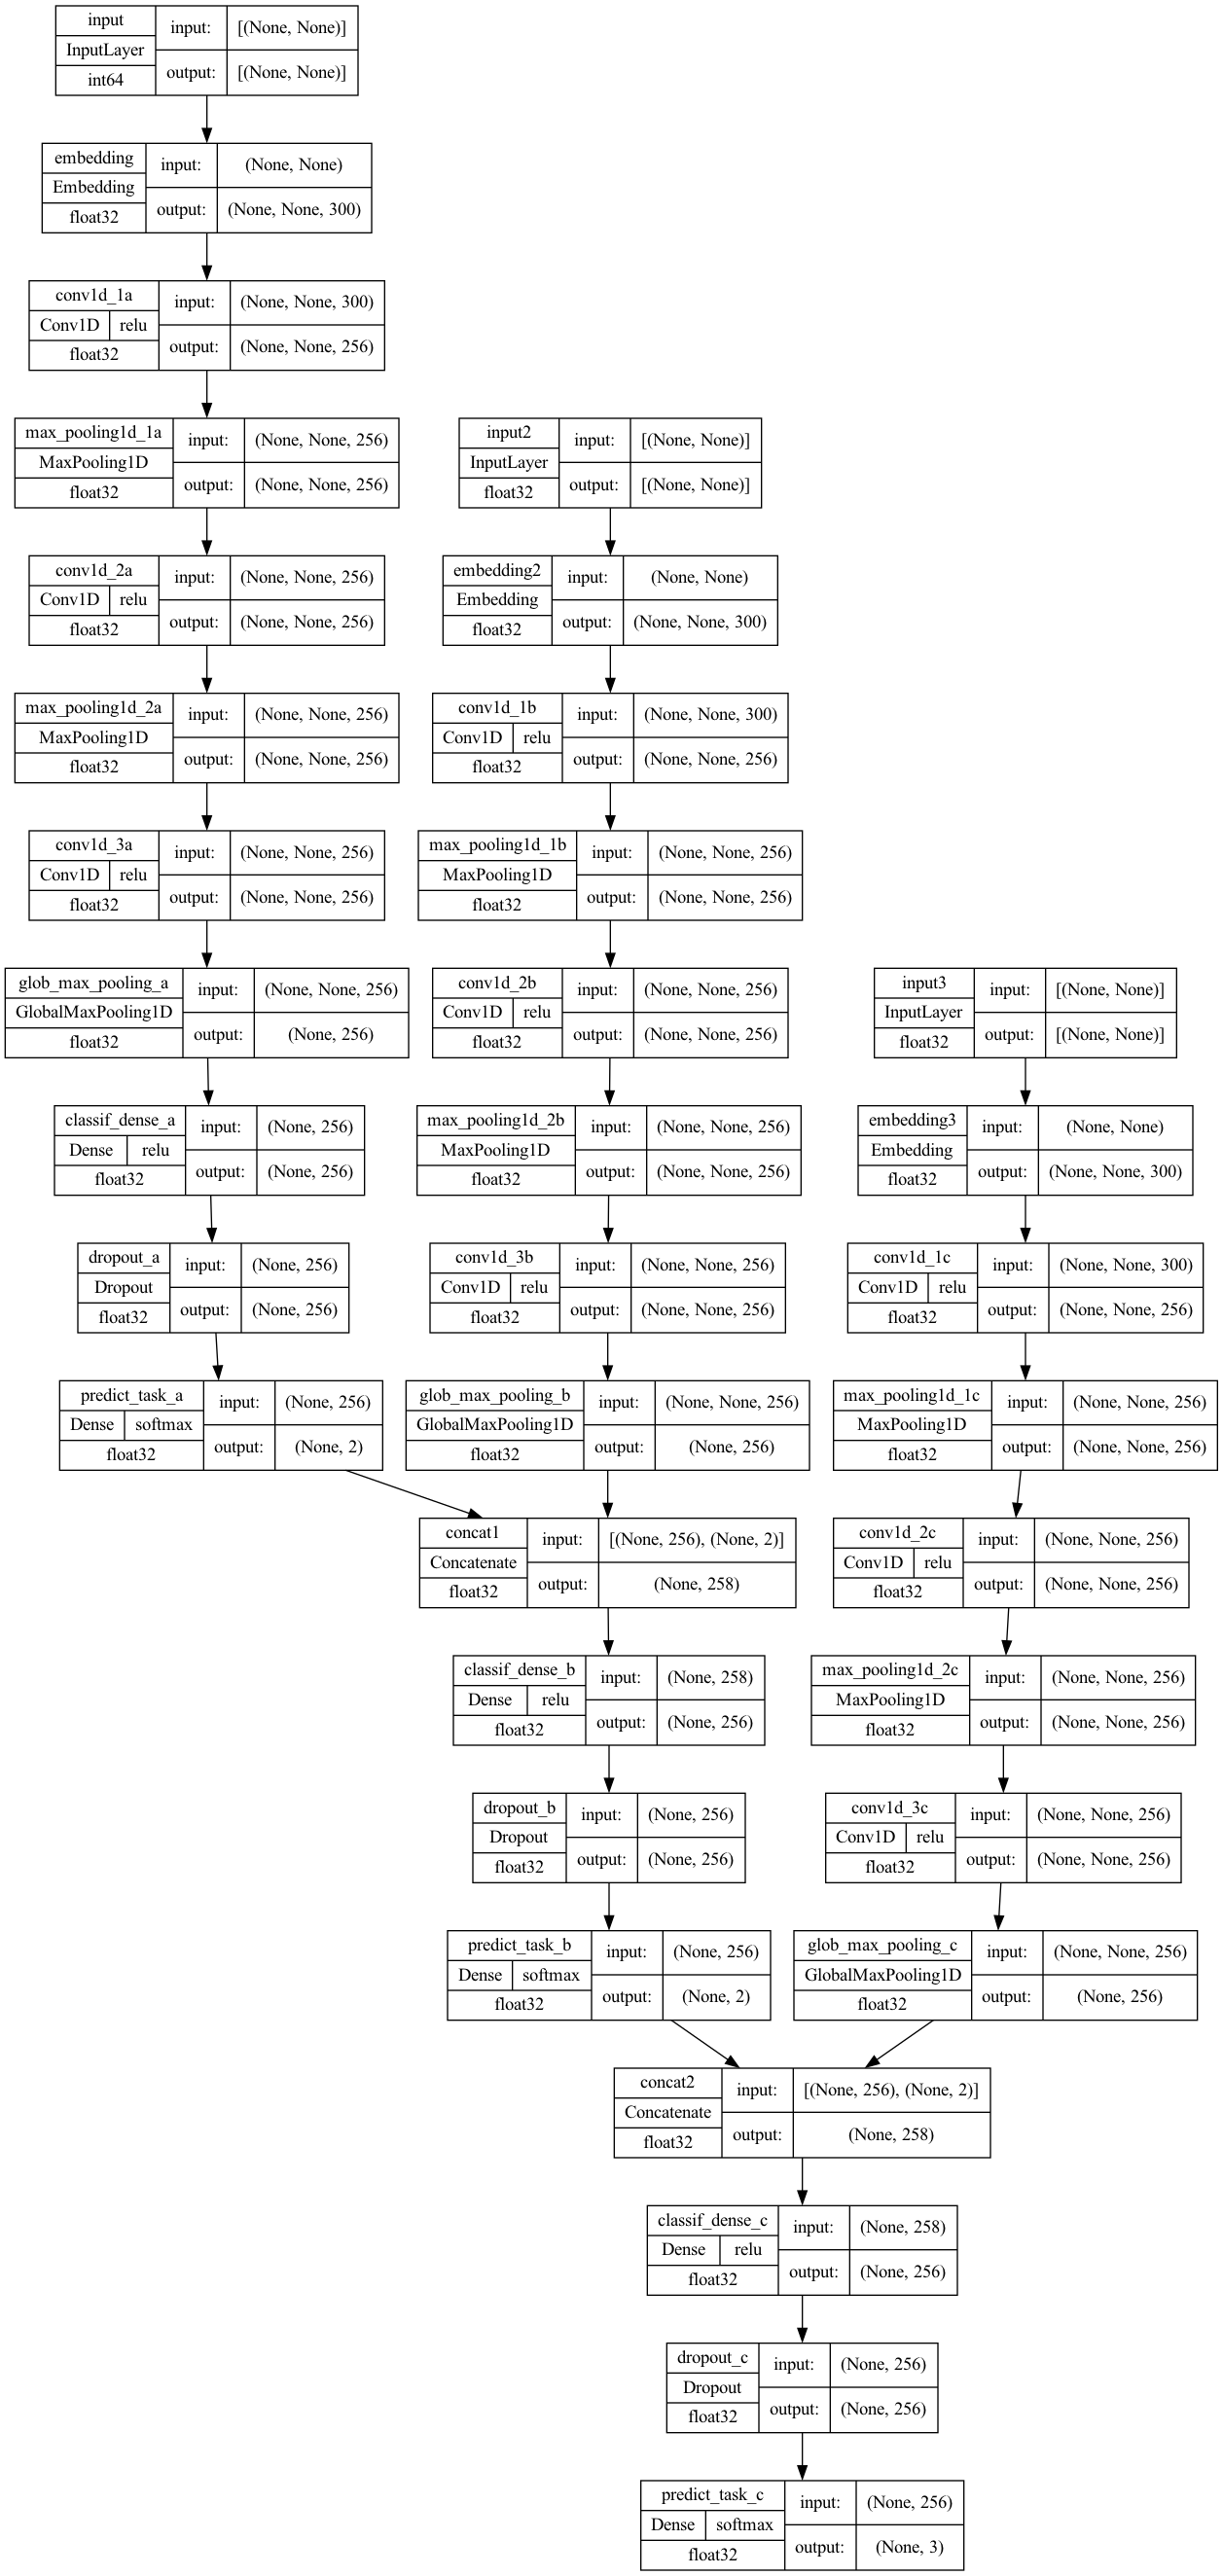

In [83]:
plot_model(best_model, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [84]:
res_test_a, res_test_b, res_test_c = best_model.predict({"input":testing_data_a, 
                            "input2": testing_data_b, 
                            "input3": testing_data_c})

7/7 [==============================] - 1s 56ms/step


In [85]:
best_a = np.argmax(res_test_a, axis=1)

target = cat_to_int_a.keys()
print(classification_report(df_test_a['label'].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

              precision    recall  f1-score   support

         NOT       0.59      0.92      0.72       100
         OFF       0.82      0.37      0.51       100

    accuracy                           0.65       200
   macro avg       0.71      0.65      0.62       200
weighted avg       0.71      0.65      0.62       200



In [86]:
best_b = np.argmax(res_test_b, axis=1)

target = cat_to_int_b.keys()
print(classification_report(df_test_b['label'].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

              precision    recall  f1-score   support

         TIN       0.56      0.98      0.72       100
         UNT       0.92      0.24      0.38       100

    accuracy                           0.61       200
   macro avg       0.74      0.61      0.55       200
weighted avg       0.74      0.61      0.55       200



In [87]:
best_c = np.argmax(res_test_c, axis=1)

target = cat_to_int_c.keys()
print(classification_report(df_test_c['label'].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

              precision    recall  f1-score   support

         GRP       0.55      0.73      0.62        66
         IND       0.51      0.82      0.63        66
         OTH       0.17      0.01      0.03        68

    accuracy                           0.52       200
   macro avg       0.41      0.52      0.43       200
weighted avg       0.40      0.52      0.42       200

